# Random Forest

## Homework #6 by Glaktionova Natalia

Bank Marketing Data Set

In [64]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, \
    accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Считываем и просматриваем данные

In [33]:
df = pd.read_csv('data/bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no




Изучаем структуру данных. 

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

Посмотрим на целевую переменную

*The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).*

In [35]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

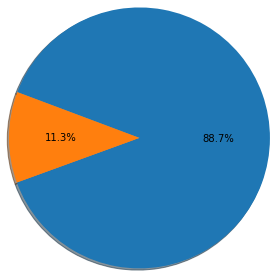

In [36]:
plt.pie(df.y.value_counts(), radius = 1.5, autopct='%1.1f%%', shadow=True,startangle=200);

In [37]:
labelencoder = LabelEncoder()
df['y'] = labelencoder.fit_transform(df['y'])

In [38]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [39]:
df.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


Преобразуем категориальные переменные

In [40]:
enc = OneHotEncoder(handle_unknown='error')
categorical = df.select_dtypes(include=[object])
numerical = df.drop(categorical,axis=1)
enc.fit(categorical)
categorical_enc = enc.transform(categorical)
categorical_enc_df = pd.DataFrame(categorical_enc.toarray())

In [41]:
df_enc = pd.concat([numerical, categorical_enc_df], axis=1)

In [42]:
df_enc.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,43,44,45,46,47,48,49,50,51,52
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Удалим duration, т.к. в описании указано

*Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.*

In [43]:
df_enc.drop(columns=['duration'], inplace=True)

**Baseline**

In [55]:
X_train, X_test, y_train, y_test = train_test_split(df_enc.drop(labels=['y'], axis=1),
                                                    df_enc['y'], test_size=0.3,
                                                    stratify=df_enc['y'], random_state=0)

In [57]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train, y_train)
pred_dummy = dummy_clf.predict(X_test)

In [59]:
stats = [accuracy_score(pred_dummy, y_test),
        precision_score(pred_dummy, y_test),
        recall_score(pred_dummy, y_test),
        f1_score(pred_dummy, y_test),
        roc_auc_score(pred_dummy, y_test)
    ]
stats

[0.8030266245852553,
 0.11781609195402298,
 0.11970802919708029,
 0.11875452570601014,
 0.5039697877850332]

**Random Forest**

In [60]:
X, y = df_enc.drop(columns=['y']), np.asarray(df["y"],dtype='int8')

In [78]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)

In [79]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [80]:
results = cross_val_score(rfc, X, y, cv=skf)

In [81]:
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 89.28%


In [86]:
rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [87]:
rfc.oob_score_

0.8905749247353598

In [88]:
parameters = {'max_features': [10, 30, 40, 62], 'min_samples_leaf': [1, 3, 5, 7], 'max_depth': [5,10,15,20]}
rf = RandomForestClassifier(n_estimators=100, random_state=42, 
                            n_jobs=-1, oob_score=True)
rcv = RandomizedSearchCV(rf, parameters, n_jobs=-1, cv=skf, verbose=1)
rcv.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.4min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estima

In [89]:
rcv.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [90]:
rcv.best_score_

0.9015247159366806

In [91]:
rcv.best_estimator_.oob_score_

0.9014276002719238